In [1]:
PATH='/home/kirana/Documents/phd/experiment1_new/DNNREC_FilmTrust'
DATAPATH='/home/kirana/Documents/final_dissertation_final/experiments/datasets/filmtrust'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import os
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import pickle
from sklearn import metrics

In [3]:
[dftrain,dfvalid,results_concat]=pickle.load(open(f'{DATAPATH}/df_side_cold_runother.pkl','rb'))

In [4]:
df=pd.concat([dftrain,dfvalid[dftrain.columns]],axis=0)

In [5]:
user_to_idx={j:i+1 for i, j in enumerate(df['userId'].unique())}
item_to_idx={j:i+1 for i,j in enumerate(df['itemId'].unique())}
idx_to_user={i+1:j for i, j in enumerate(df['userId'].unique())}
idx_to_item={i+1:j for i,j in enumerate(df['itemId'].unique())}

In [6]:
dftrain['user_idx']=[user_to_idx[i] for i in dftrain['userId']]
dftrain['item_idx']=[item_to_idx[i] for i in dftrain['itemId']]

In [7]:
dfvalid['user_idx']=[user_to_idx[i] for i in dfvalid['userId']]
dfvalid['item_idx']=[item_to_idx[i] for i in dfvalid['itemId']]

In [8]:
pickle.dump([df, dftrain,dfvalid,idx_to_user,idx_to_item,item_to_idx,user_to_idx],open(f'{DATAPATH}/reads.pkl','wb'))

### Dataset and DataLoader

In [9]:
class cfdata (torch.utils.data.dataset.Dataset):
    def __init__(self,dfX,dfY):
        self.dfX,self.dfY=dfX,dfY
        
    def __len__ (self):
        return self.dfX.shape[0]
    
    def __getitem__ (self, idx):
        return torch.LongTensor(self.dfX.iloc[idx].values),torch.FloatTensor([self.dfY.values[idx]])

In [10]:
dstrain=cfdata(dftrain[['user_idx','item_idx']],dftrain['rating'])
dsvalid=cfdata(dfvalid[['user_idx','item_idx']],dfvalid['rating'])

In [11]:
dftrain.shape

(32036, 24)

In [12]:
bs=32

In [13]:
dltrain=DataLoader(dstrain,bs,True)

In [14]:
dlvalid=DataLoader(dsvalid,bs,False)

In [15]:
len(user_to_idx),len(item_to_idx)

(1508, 2071)

## Model Architecture

In [18]:
n_users=len(user_to_idx)
n_items=len(item_to_idx)
n_emb_user=50
n_emb_item=50
min_rating=min(dftrain['rating'])
max_rating=max(dftrain['rating'])
dropout_e=0.05

In [19]:
n_users

1508

In [20]:
class cf(nn.Module):    
    def __init__(self,n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,dropout_e=0.01):
        super().__init__()
        self.n_users,self.n_emb_user,self.n_emb_item,self.n_items,self.min_rating,self.max_rating=\
                    n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating
        self.dropout_e=dropout_e
        self.create_architecture()
        self.init_parameters()
        self.criterion=nn.MSELoss()
        
        
    def create_architecture(self):
        self.emb_user=nn.Embedding(self.n_users+1,self.n_emb_user)
        self.emb_item=nn.Embedding(self.n_items+1,self.n_emb_item)
        self.emb_dropout=nn.Dropout(self.dropout_e)
        self.ub=nn.Embedding(self.n_users+1,1)
        self.ib=nn.Embedding(self.n_items+1,1)

        self.sigmoid=nn.Sigmoid()
        
        
    def init_parameters(self):
        nn.init.kaiming_normal_(self.emb_user.weight.data)
        nn.init.kaiming_normal_(self.emb_item.weight.data)
        nn.init.kaiming_normal_(self.ub.weight.data)
        nn.init.kaiming_normal_(self.ib.weight.data)

       
    def forward (self,Xb,Yb):               
        users=self.emb_dropout(self.emb_user(Xb[:,0]))
        items=self.emb_dropout(self.emb_item(Xb[:,1]))
        users_bias=self.emb_dropout(self.ub(Xb[:,0]))
        items_bias=self.emb_dropout(self.ib(Xb[:,1]))

        out=(users*items).sum(1)+users_bias.squeeze()+items_bias.squeeze()
        out=self.sigmoid(out)
        preds=out*(self.max_rating-self.min_rating)+self.min_rating
        preds=preds.view(-1,1)
        loss=self.criterion(preds,Yb)
        return preds,loss

In [21]:
n_users

1508

In [22]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,dropout_e)

In [23]:
cfobj

cf(
  (emb_user): Embedding(1509, 50)
  (emb_item): Embedding(2072, 50)
  (emb_dropout): Dropout(p=0.05)
  (ub): Embedding(1509, 1)
  (ib): Embedding(2072, 1)
  (sigmoid): Sigmoid()
  (criterion): MSELoss()
)

In [24]:
for Xb, Yb in dltrain:
    break

In [25]:
Xb.shape, Yb.shape

(torch.Size([32, 2]), torch.Size([32, 1]))

In [26]:
cfobj.forward(Xb,Yb)

(tensor([[3.3524],
         [1.4907],
         [1.7232],
         [0.6492],
         [3.8112],
         [0.8801],
         [3.2309],
         [3.2556],
         [1.9324],
         [2.4322],
         [3.1643],
         [3.5568],
         [1.1630],
         [0.9701],
         [3.9879],
         [0.9880],
         [3.6226],
         [2.1537],
         [0.7587],
         [1.7076],
         [0.6362],
         [1.0027],
         [2.0937],
         [1.5388],
         [3.2540],
         [1.1408],
         [3.4548],
         [1.5569],
         [3.8452],
         [3.3387],
         [2.4784],
         [2.6806]], grad_fn=<ViewBackward>),
 tensor(2.1871, grad_fn=<MseLossBackward>))

## Learner

In [27]:
class Learner():
    def __init__(self,model,optimizer,metric_fn,device,bptt=12,print_every=5,clip_val=None,\
                 cycle_mult=0,lr_decay=0.7,wd_mult=1.1,start_lr=2e-2, end_lr=5e-4,error_type="mse"):
        self.model,self.optimizer,self.metric_fn,self.device,self.print_every,self.bptt,self.losses,self.clip_val=\
            model,optimizer,metric_fn,device,print_every,bptt,[],clip_val
        self.n_epochs=1
        self.cycle_mult,self.lr_decay=cycle_mult,lr_decay
        self.wd_mult=wd_mult
        for param_group in self.optimizer.param_groups:
            self.start_lr=param_group['lr']
            self.start_wd=param_group['weight_decay']
        self.wd=self.start_wd
        self.lr=self.start_lr
        self.end_lr=end_lr
        self.n_epoch=0
        self.lrs=[1e-2,5e-3,1e-4,5e-4]
        self.preds,self.preds_valid,self.trainY,self.actual=[],[],[],[]
        self.ratio=self.end_lr/self.start_lr
        self.num_steps=self.cycle_mult
        self.reset_cycle=self.cycle_mult
        self.error_type=error_type
        self.scores=[]
        self.generate_scores=False
        
    def fit (self,Xb,Yb,mode_train=True):
        if mode_train:
            self.model.train()
        else:
            self.model.eval()
        
        #import pdb
        #pdb.set_trace()
        preds,loss=self.model(Xb,Yb)

     
        if mode_train:
            if 1==0:
                lr =self.lrs[torch.randint(0,4,(1,))]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        myloss=loss.item()
    
        
        with torch.no_grad():
            if self.error_type == "mse":
                acc=nn.L1Loss() (preds,Yb)
                myrmse=np.sqrt(myloss)
            else:
                acc=nn.MSELoss() (preds,Yb)
                myrmse=np.sqrt(acc.item())
            acc=acc.item()
                 
        if mode_train==False:
            if self.generate_scores:
                self.scores.append(preds.detach().cpu().numpy().flatten())
        del preds
        del loss
        
        if self.clip_val is not None:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_val)
        
        return myloss, acc, myrmse
    
    def lr_find (self,start_lr,end_lr,iterator,n_batch):
        losses,lrs=[],[]
        ratio=end_lr/start_lr
        num_steps=n_batch
        lr=start_lr
        for i in range(num_steps):            
            lr=lr*(end_lr/start_lr)**(1/num_steps)
            lrs.append(lr)
        self.lrs=lrs
        self.run_epoch(iterator,mode_train=True,lrs=lrs)
    
    def run_epoch(self,iterator,mode_train,lrs=None):
        epoch_loss,epoch_acc,i,k=0,0,0,0
        epoch_rmse=0

        for Xb,Yb in iterator:
            Xb=Xb.to(self.device)
            Yb=Yb.to(self.device)
            
            if lrs is not None:
                lr=lrs[k]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr 
            
            loss,acc,myrmse=self.fit(Xb,Yb,mode_train)
            
            if lrs is not None:
                self.losses.append(loss)

            epoch_loss+=loss
            epoch_acc+=acc
            epoch_rmse+=myrmse
            
            k=k+1
            if k%self.print_every == 0:
                if k:
                    print (f'Batch:{k} {epoch_loss/(k)}  ')  
                    torch.cuda.empty_cache()

        epoch_loss=epoch_loss/len(iterator)
        epoch_acc=epoch_acc/len(iterator)
        epoch_rmse=epoch_rmse/len(iterator)
            
        return epoch_loss,epoch_acc,epoch_rmse
    
    def plot_lrs(self, n_roll=1,ylim=None,xlim=None):
        import seaborn as sns
        ax=sns.lineplot(x=self.lrs,y=pd.Series(self.losses).rolling(n_roll).mean())
        ax.set_xscale('log')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate')
        if ylim is not None:
            plt.ylim(ylim)
        if xlim is not None:
            plt.xlim(xlim)

     
    def run_epochs(self,dltrain,dlvalid,n_epochs=1):              
        for epoch in range(n_epochs):                
            loss,acc,rmse=self.run_epoch(dltrain,True)

            lossv,accv,rmsev=self.run_epoch(dlvalid,mode_train=False)
           
            if self.error_type=="mse":
                loss_mse=loss
                loss_rmse=rmse
                loss_mae=acc
                lossv_mse=lossv
                lossv_rmse=rmsev
                lossv_mae=accv
                
            else:
                loss_mse=acc
                loss_rmse=rmse
                loss_mae=loss
                lossv_mse=accv
                lossv_rmse=rmsev
                lossv_mae=lossv
            
            print (f'Epoch:{epoch} Learning rate {self.lr} Weight Decay {self.wd} Train Loss:{loss} \
                Valid Loss:{lossv} Train RMSE:{loss_rmse} Valid RMSE:{lossv_rmse} Train MSE:{loss_mse} Valid MSE:{lossv_mse} \
                Train MAE:{loss_mae} Valid MAE:{lossv_mae}')

              
         
     
            if self.cycle_mult:
                if self.n_epoch==self.reset_cycle:
                    self.lr=self.start_lr
                    self.wd=self.start_wd
                    self.reset_cycle*=self.cycle_mult
                    #reset_cycle=self.n_epoch+reset_cycle
                    self.n_epoch=0
                    self.ratio=self.end_lr/self.start_lr
                    self.num_steps=self.reset_cycle
                else:
                    #self.lr*=(self.lr_decay**self.n_epoch)  
                    #if self.n_epoch>1:
                    self.wd*=self.wd_mult
                    self.lr=self.lr*(self.end_lr/self.start_lr)**(1/self.num_steps)
                    self.n_epoch+=1
        

                
            for param_group in self.optimizer.param_groups:
                param_group['lr']=self.lr
                param_group['weight_decay']=self.wd
          
     

In [28]:
if 1==1:
    del cfobj
    torch.cuda.empty_cache()

In [29]:
device='cuda:0'

In [30]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,dropout_e)

In [31]:
cfobj=cfobj.to(device)

In [32]:
cfobj

cf(
  (emb_user): Embedding(1509, 50)
  (emb_item): Embedding(2072, 50)
  (emb_dropout): Dropout(p=0.05)
  (ub): Embedding(1509, 1)
  (ib): Embedding(2072, 1)
  (sigmoid): Sigmoid()
  (criterion): MSELoss()
)

In [33]:
len(dltrain)

1002

In [34]:
wd=1e-4
optimizer=torch.optim.Adam(cfobj.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,5000,0.25,cycle_mult=0)

In [35]:
learner.lr_find(1e-4,1e-1,dltrain,len(dltrain))

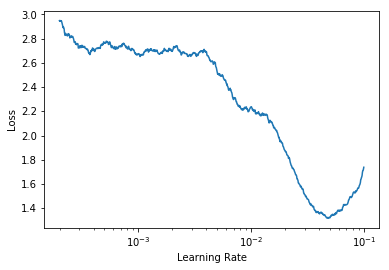

In [36]:
learner.plot_lrs(100)

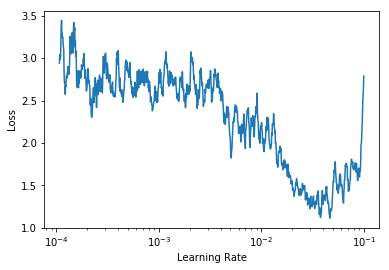

In [37]:
learner.plot_lrs(10)

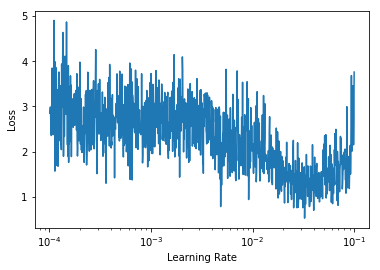

In [38]:
learner.plot_lrs(1)

In [39]:
del cfobj
torch.cuda.empty_cache()

In [40]:
wd=1e-4

In [41]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,dropout_e)
cfobj=cfobj.to(device)

In [42]:
device

'cuda:0'

In [43]:
optimizer=torch.optim.Adam(cfobj.parameters(),lr=5e-2,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,16000,0.25,cycle_mult=2,start_lr=5e-2,end_lr=5e-3,wd_mult=1.2)

In [44]:
learner.run_epochs(dltrain,dlvalid,16)

Epoch:0 Learning rate 0.05 Weight Decay 0.0001 Train Loss:1.6645289722554937                 Valid Loss:1.614669345387625 Train RMSE:1.2776946438461187 Valid RMSE:1.2564828374458297 Train MSE:1.6645289722554937 Valid MSE:1.614669345387625                 Train MAE:0.9817671498019777 Valid MAE:0.9501246432645605
Epoch:1 Learning rate 0.0158113883008419 Weight Decay 0.00012 Train Loss:1.2782336351519334                 Valid Loss:1.1588815007734736 Train RMSE:1.1187570362373929 Valid RMSE:1.0640427972914621 Train MSE:1.2782336351519334 Valid MSE:1.1588815007734736                 Train MAE:0.834663455833694 Valid MAE:0.8099677338512665
Epoch:2 Learning rate 0.005000000000000001 Weight Decay 0.000144 Train Loss:0.7649610397552777                 Valid Loss:0.9311691921785337 Train RMSE:0.8630875777329238 Valid RMSE:0.9536796536531897 Train MSE:0.7649610397552777 Valid MSE:0.9311691921785337                 Train MAE:0.6410702225155459 Valid MAE:0.7295865331767896
Epoch:3 Learning rate 0.0

In [45]:
learner.generate_scores=True

In [46]:
learner.run_epoch(dlvalid,False)

(0.6817921971509217, 0.6616081401295618, 0.8159035073555909)

In [47]:
np.concatenate(learner.scores)

array([2.061562 , 3.5026479, 3.058094 , ..., 2.7815378, 2.7169743,
       2.3909013], dtype=float32)

In [48]:
dfvalid['pred_cf']=np.concatenate(learner.scores)

In [49]:
np.sqrt(metrics.mean_squared_error(dfvalid['rating'],dfvalid['pred_cf']))

0.8244462447232579

In [50]:
def score_by_group (dfvalid,predVar,groupVar='cold_start_group',method='global_avg'):
    scores=[]
    mae_scores=[]
    rmse_scores=[]
    r2_scores=[]
    groups=dfvalid[groupVar].value_counts().index.tolist()
    for group in groups:
        df=dfvalid.loc[dfvalid[groupVar]==group]
        actual=df['rating']
        score=metrics.mean_squared_error(df['rating'],df[predVar])
        rmse_score=np.sqrt(metrics.mean_squared_error(df['rating'],df[predVar]))
        mae_score=metrics.mean_absolute_error(df['rating'],df[predVar])
        r2_score=metrics.r2_score(df['rating'],df[predVar])
        scores.append(score)
        mae_scores.append(mae_score)
        rmse_scores.append(rmse_score)
        r2_scores.append(r2_score)
    return pd.DataFrame({'method':method, 'mse':scores, 'rmse':rmse_scores, 'mae':mae_scores, 'r2_score':r2_scores, 'Cold Start Group':groups})

In [51]:
result_cf=pd.concat([score_by_group(dfvalid,'pred_cf','cold_start_group','cf'),score_by_group(dfvalid,'pred_cf','cold_start_bucket','cf'),\
score_by_group(dfvalid,'pred_cf','flag_train','cf')],axis=0)
result_cf

,method,mse,rmse,mae,r2_score,Cold Start Group
0,cf,0.639133,0.799458,0.636051,0.216071,No-cold-start
1,cf,1.026170,1.013001,0.866401,-0.018092,User-Cold-Start
2,cf,1.083329,1.040831,0.843148,-0.161179,Item-Cold_start
3,cf,1.162469,1.078179,0.916640,-0.002129,User-Item-cold-start
0,cf,0.639133,0.799458,0.636051,0.216071,0
1,cf,1.041200,1.020392,0.864829,-0.017500,1
0,cf,0.679712,0.824446,0.659140,0.187477,0


In [52]:
mtx_user_emb=cfobj.emb_user.weight.data.cpu().numpy()
mtx_item_emb=cfobj.emb_item.weight.data.cpu().numpy()

In [53]:
user_bias_emb=cfobj.ub.weight.data.cpu().numpy()
item_bias_emb=cfobj.ib.weight.data.cpu().numpy()

In [54]:
mtx_user_emb.shape, mtx_item_emb.shape, user_bias_emb.shape, item_bias_emb.shape

((1509, 50), (2072, 50), (1509, 1), (2072, 1))

In [55]:
pickle.dump([mtx_user_emb,mtx_item_emb,user_bias_emb,item_bias_emb],open(f'{DATAPATH}/wts_embs','wb'))

In [56]:
results_concat.shape

(70, 6)

In [57]:
results_concat=pd.concat([results_concat,result_cf],axis=0)

In [58]:
pickle.dump([df,dftrain,dfvalid,idx_to_user,idx_to_item,item_to_idx,user_to_idx,results_concat],open(f'{DATAPATH}/df_side_cold_runother_cf.pkl','wb'))

In [59]:
results_concat

,method,mse,rmse,mae,r2_score,Cold Start Group
0,biasedmatrixfactorization,0.638513,0.799070,0.622871,0.216831,No-cold-start
1,biasedmatrixfactorization,0.925556,0.962058,0.771413,0.081731,User-Cold-Start
2,biasedmatrixfactorization,1.016274,1.008104,0.775404,-0.089305,Item-Cold_start
3,biasedmatrixfactorization,1.649868,1.284472,1.099969,-0.422300,User-Item-cold-start
0,biasedmatrixfactorization,0.638513,0.799070,0.622871,0.216831,0
1,biasedmatrixfactorization,0.971243,0.985517,0.786175,0.050864,1
0,biasedmatrixfactorization,0.672094,0.819813,0.639352,0.196583,0
0,svdplusplus,0.648519,0.805307,0.643882,0.204558,No-cold-start
1,svdplusplus,0.939454,0.969254,0.780966,0.067942,User-Cold-Start
2,svdplusplus,0.964594,0.982138,0.773659,-0.033912,Item-Cold_start
